In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import h5py
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

import seaborn as sns

from scipy.stats import spearmanr, pearsonr, rankdata

C:\Users\nbbwang\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:

with h5py.File("/Users/nbbwang/Documents/Lee Lab/AD_project/analyses/NEW_FULL_PIPELINE/Data_Processing/ProcessedData/combined_files/01_resid_postcombat/ACT_MSBBRNA_ROSMAP.h5", 'r') as hf:
    gene_symbols = hf["gene_symbols"][:].astype(str)
    
phenotypes = ['CERAD','BRAAK','PLAQUES','TANGLES','ABETA_IHC','TAU_IHC']
method = "MTL"


In [4]:
phen_dict = {"all": ['CERAD','BRAAK','PLAQUES','TANGLES','ABETA_IHC','TAU_IHC'], 
             "abeta": ['CERAD','PLAQUES','ABETA_IHC'],
            "tau": ['BRAAK','TANGLES','TAU_IHC']}

In [5]:
# ranks such that most positive value has rank 1
def weights_to_rankings(weights, direction="positive"):
    if direction=="positive":
        return  len(weights) - rankdata(weights)
    elif direction =="negative":
        return len(weights) - rankdata(-1*weights)
    else:
        return len(weights) - rankdata(abs(weights))


In [6]:
if method=="MTL":
    num_reps = 101
elif method == "MLP_baselines":
    num_reps = 10

In [12]:
num_cats_overlaps = num_reps
top_x_genes = 500


rep_gws = []
for i in range(num_reps):
    if i%10==0:
        print(i)
        
    p_by_g_gw = np.loadtxt("/Users/nbbwang/Documents/Lee Lab/AD_project/analyses/NEW_FULL_PIPELINE/fgsea/data/IG_weights_forR/origGE/reps/weighted_avg_high_vs_low_path/%s/%i/outputs/G_by_output_type.txt"%(method,i)).T
    rep_gws.append(p_by_g_gw)
rep_gws = np.array(rep_gws)

rep_ranks = {}
for direction in ["positive", "negative"]:
    rep_ranks[direction] = np.zeros([len(rep_gws), len(phenotypes), len(gene_symbols)])
    for i in range(num_reps):
        for p in range(len(phenotypes)):
            rep_ranks[direction][i,p,:] = weights_to_rankings(rep_gws[i,p,:], direction).astype(int)

0
10
20
30
40
50
60
70
80
90
100


In [13]:
tops = [100,500,1000,2000]
agreement_fracs = {}
for direction in ["positive", "negative"]:
    print(direction)
    agreement_fracs[direction] = []
    for top_num in tops:
        print(top_num)
        agreement_frac = []
        currep = 1
        cur_top = []

        for currep in range(1,101):
            new_top = np.argsort(np.mean(np.mean(rep_ranks[direction],axis=1)[:currep,:],axis=0))[:top_num]
            agreement_frac.append(len(np.intersect1d(cur_top,new_top))/top_num)

            cur_top=new_top
        agreement_fracs[direction].append(agreement_frac)

positive
100
500
1000
2000
negative
100
500
1000
2000


In [14]:
rep_ranks["negative"].shape

(101, 6, 14591)

In [15]:
import matplotlib
cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]
warm_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cmaplist[3], cmaplist[6]])
cold_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [cmaplist[5], cmaplist[0]])

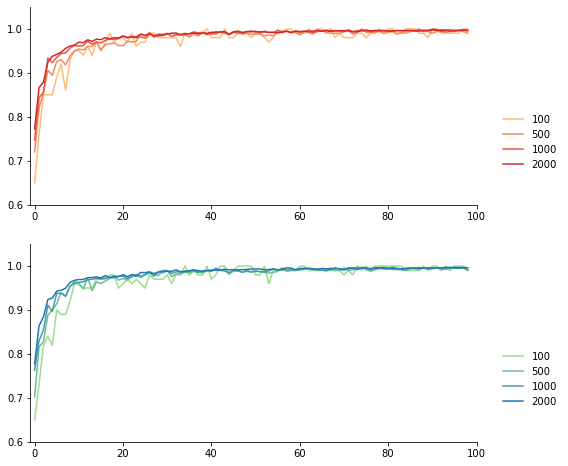

In [16]:
colors = {"negative": [cold_cmap(x) for x in np.arange(4)/3],
         "positive": [warm_cmap(x) for x in np.arange(4)/3]}

f,ax=plt.subplots(2,1,figsize=(8,8))
for i,direction in enumerate(agreement_fracs.keys()):
    for j,a in enumerate(agreement_fracs[direction]):
        ax[i].plot(a[1:], c=colors[direction][j])
        ax[i].set_ylim(.6,1.05)

        ax[i].legend(tops, bbox_to_anchor=(1.2, 0.5), frameon=False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].set_xlim(-1,100)

In [18]:
scores = rep_ranks["negative"]/(len(gene_symbols)-1)
consensus_scores = np.mean(scores,axis=0)

In [21]:
os.makedirs("CONSENSUS_SCORES_191017_%s"%method)

In [22]:
for i,p in enumerate(phenotypes):
    to_save_c_scores = consensus_scores[i]
    
    scores_df = pd.DataFrame(np.vstack([gene_symbols,to_save_c_scores]).T, columns=["gene", "score"])
    scores_df["score"] = scores_df["score"].astype(float)
    scores_df = scores_df.sort_values("score", ascending=False)
    scores_df = scores_df.reset_index(drop=True)
    scores_df.to_csv("CONSENSUS_SCORES_191017_%s/%s.csv"%(method,p), index=False)
for p_group in ["all", "abeta", "tau"]:
    p_idx = np.where(np.in1d(phenotypes, phen_dict[p_group]))[0]
    to_save_c_scores = np.mean(consensus_scores[p_idx],axis=0)
    
    scores_df = pd.DataFrame(np.vstack([gene_symbols,to_save_c_scores]).T, columns=["gene", "score"])
    scores_df["score"] = scores_df["score"].astype(float)
    scores_df = scores_df.sort_values("score", ascending=False)
    scores_df = scores_df.reset_index(drop=True)
    scores_df.to_csv("CONSENSUS_SCORES_191017_%s/%s-related.csv"%(method,p_group), index=False)

### compiling all of these results into one spread sheet:

In [55]:
current_ranking = pd.read_csv("CONSENSUS_SCORES_191017_%s/all-related.csv"%method, names=["gene", "all-related_score"], skiprows=1)

In [24]:
for group in [x+"-related" for x in ["abeta", "tau"]] + phenotypes:
    new_df = pd.read_csv("CONSENSUS_SCORES_191017_%s/%s.csv"%(method,group), names=["gene", "%s_score"%group], skiprows=1)
    current_ranking = current_ranking.merge(new_df, on="gene", how="left")

In [25]:
current_ranking.to_csv("CONSENSUS_SCORES_191017_%s/ALL_CONSENSUS_SCORES.csv"%method, index=False)

In [52]:
scores_df

,gene,score
0,FPR3,0.999553
1,ARL17A,0.998310
2,EFHB,0.997546
3,RPL9,0.997525
4,GFAP,0.997186
...,...,...
14586,USP9Y,0.004999
14587,KDM5D,0.003836
14588,KRT86,0.003808
14589,CCDC134,0.002519


In [59]:
for i in range(num_reps):
    top_x_neg.append(gene_symbols[np.argsort(np.sum(rep_ranks["negative"][i],axis=0))[:top_genes_num]])
    top_x_pos.append(gene_symbols[np.argsort(np.sum(rep_ranks["positive"][i],axis=0))[:top_genes_num]])

In [60]:
phen_ids = {'CERAD':0,'BRAAK':1,'PLAQUES':2,'TANGLES':3,'ABETA_IHC':4,'TAU_IHC':5}

phen_dict = {"all": ['CERAD','BRAAK','PLAQUES','TANGLES','ABETA_IHC','TAU_IHC'], 
             "abeta": ['CERAD','PLAQUES','ABETA_IHC'],
            "tau": ['BRAAK','TANGLES','TAU_IHC']}



    
    

In [61]:
def get_top_Xs(phens, direction, top_genes_num):
    row_idxes = np.array([phen_ids[x] for x in phen_dict[phens]])
    
    
    rep_ranks = []
    for i in range(num_reps):
        rep_ranks_i = []
        for p in row_idxes:
            rep_ranks_i.append(weights_to_rankings(rep_gws[i,p,:], direction).astype(int))
        rep_ranks.append(rep_ranks_i)

    rep_ranks = np.array(rep_ranks)
    
    top_X_genes = []
    for i in range(num_reps):
        top_X_genes.append(gene_symbols[np.argsort(np.sum(rep_ranks[i],axis=0))[:top_genes_num]])
    
    return(np.array(top_X_genes))
    

In [62]:
phen_dict.keys()

dict_keys(['all', 'abeta', 'tau'])

all negative
all positive
abeta negative
abeta positive
tau negative
tau positive


Text(0, 0.5, '# reps capturing gene')

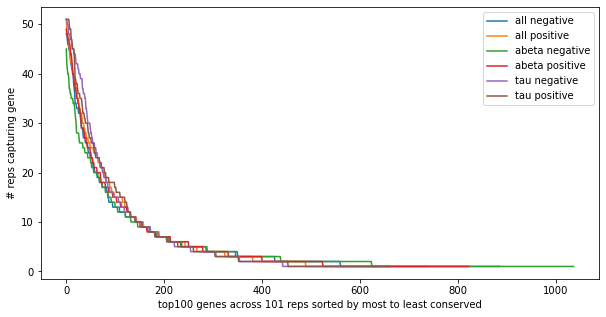

In [63]:
plt.figure(figsize=(10,5))
leg = []
for PHENS in phen_dict.keys():
    for direction in ["negative", "positive"]:
        leg.append(PHENS + " " + direction)
        
        print(PHENS, direction)
        
        top_x_genes = get_top_Xs(PHENS, direction, top_genes_num)
        top_x_genes = top_x_genes[50:]
        # get list of genes in any top X list & the number of times the gene appears in any top X list
        genes_in_any_top, num_top_appearances = np.unique(top_x_genes, return_counts=True)

        # for reps that have the gene in the top X list, what's the average ranking? 
        # (i.e., we ignore the reps that dont have a given gene in the top X list)
        mean_rankings_within_tops = []
        for g in genes_in_any_top:
            mean_rankings_within_tops.append(np.mean(np.hstack([np.where(x==g) for x in top_x_genes])))
        mean_rankings_within_tops = np.round(np.array(mean_rankings_within_tops),2)

        # generate a ranking where we sort by first, the number of reps with genes in the top X list, then within that overlap size, 
        # sort by the average ranking for the reps that had the gene in the top X
        df = pd.DataFrame(np.vstack([genes_in_any_top, num_top_appearances, mean_rankings_within_tops]).T, columns=["gene","num_reps_appearing", "mean_rank_when_appearing"])
        gene_order = df.sort_values(['num_reps_appearing', 'mean_rank_when_appearing'], ascending=[False, True]).index.values

        new_df = df.loc[gene_order]

#         if not os.path.isdir("/Users/nbbwang/Documents/humangene2RNAilib_newWithRBH/SUBFOLDERS2/%s_%s/"%(direction, PHENS)):
#             os.makedirs("/Users/nbbwang/Documents/humangene2RNAilib_newWithRBH/SUBFOLDERS2/%s_%s/"%(direction, PHENS))
        
#         np.savetxt("/Users/nbbwang/Documents/humangene2RNAilib_newWithRBH/SUBFOLDERS2/%s_%s/examplegenelist.txt"%(direction, PHENS), new_df[new_df["num_reps_appearing"].astype(float)>=5]["gene"].astype(str), fmt="%s")
       
    
        if not os.path.isdir("ranking_lists"):
            os.makedirs("ranking_lists")
            
        new_df["num_reps_appearing"] = new_df["num_reps_appearing"].astype(int)
        new_df = new_df.sort_values("num_reps_appearing", ascending=False)
#         new_df.to_csv("ranking_lists/%s_%s.txt"%(direction, PHENS), index=False)
#         print(90, len(new_df[new_df["num_reps_appearing"]>= 90]))
#         print(new_df[new_df["num_reps_appearing"]>= 90]))
#         print(75, len(new_df[new_df["num_reps_appearing"]>= 75]))
#         print(50, len(new_df[new_df["num_reps_appearing"]>= 50]))
#         print(90, len(new_df))

        
        plt.plot(np.arange(len(new_df["num_reps_appearing"].values)), new_df["num_reps_appearing"].values)
plt.legend(leg)
plt.xlabel("top100 genes across 101 reps sorted by most to least conserved")
plt.ylabel("# reps capturing gene")

all negative
all positive
abeta negative
abeta positive
tau negative
tau positive


Text(0, 0.5, '# reps capturing gene')

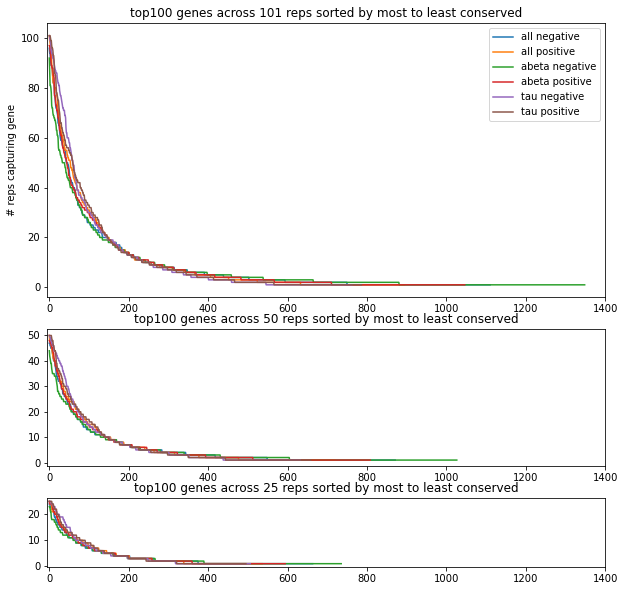

In [64]:
fig, axes = plt.subplots(3,1,figsize=(10,10), gridspec_kw = {'height_ratios':[4,2, 1]})
leg = []
for PHENS in phen_dict.keys():
    for direction in ["negative", "positive"]:
        leg.append(PHENS + " " + direction)
        
        print(PHENS, direction)
        
        top_x_genes_ = get_top_Xs(PHENS, direction, top_genes_num)
        
        

        
        
        for i,num_tops in enumerate([101,50,25]):
            top_x_genes = top_x_genes_[::-1][:num_tops]
        
            genes_in_any_top, num_top_appearances = np.unique(top_x_genes, return_counts=True)

            mean_rankings_within_tops = []
            for g in genes_in_any_top:
                mean_rankings_within_tops.append(np.mean(np.hstack([np.where(x==g) for x in top_x_genes])))
            mean_rankings_within_tops = np.round(np.array(mean_rankings_within_tops),2)

            df = pd.DataFrame(np.vstack([genes_in_any_top, num_top_appearances, mean_rankings_within_tops]).T, columns=["gene","num_reps_appearing", "mean_rank_when_appearing"])
            gene_order = df.sort_values(['num_reps_appearing', 'mean_rank_when_appearing'], ascending=[False, True]).index.values

            new_df = df.loc[gene_order]

            if not os.path.isdir("ranking_lists"):
                os.makedirs("ranking_lists")

            new_df["num_reps_appearing"] = new_df["num_reps_appearing"].astype(int)
            new_df = new_df.sort_values("num_reps_appearing", ascending=False)


            axes[i].plot(np.arange(len(new_df["num_reps_appearing"].values)), new_df["num_reps_appearing"].values)
            axes[i].set_xlim(-5,1400)
            axes[i].set_title("top100 genes across %i reps sorted by most to least conserved"%num_tops)

axes[0].legend(leg)
axes[0].set_ylabel("# reps capturing gene")

### Progressive analysis:

all negative
all positive
abeta negative
abeta positive
tau negative
tau positive


Text(0.5, 0, 'Training run')

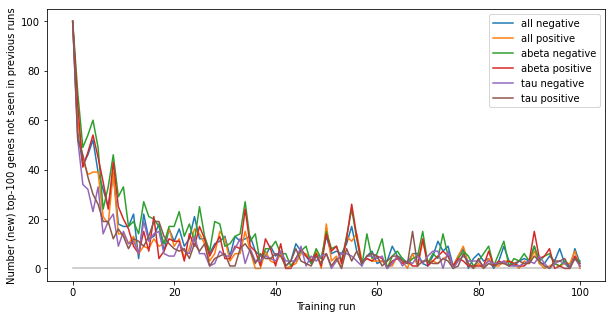

In [65]:
plt.figure(figsize=(10,5))
leg = []
for PHENS in phen_dict.keys():
    for direction in ["negative", "positive"]:
        leg.append(PHENS + " " + direction)
        
        print(PHENS, direction)
        
        top_x_genes = get_top_Xs(PHENS, direction, top_genes_num)
        
        current_known_genes = np.array([])
        new_genes = []
        for rep in range(101):
            new_genes.append(len(np.setdiff1d(top_x_genes[rep], current_known_genes)))
            current_known_genes = np.union1d(current_known_genes, top_x_genes[rep])

#         plt.plot(np.arange(101), np.sort(new_genes)[::-1])
        plt.plot(np.arange(101), (new_genes))

#         plt.plot(np.arange(101), new_genes)
plt.legend(leg)
plt.plot(np.arange(101), [0]*101, color="grey", alpha=.5)
plt.ylabel("Number (new) top-100 genes not seen in previous runs")
plt.xlabel("Training run")

all negative
all positive
abeta negative
abeta positive
tau negative
tau positive


Text(0, 0.5, 'fraction of final top genes')

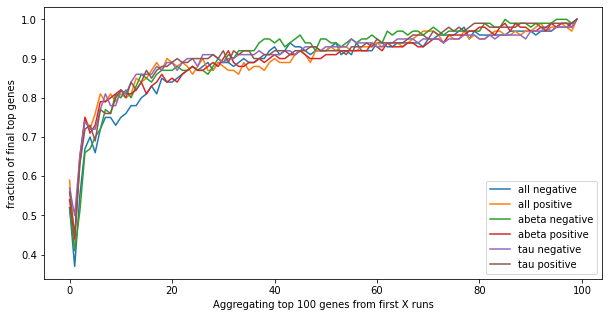

In [66]:
plt.figure(figsize=(10,5))
leg = []
for PHENS in phen_dict.keys():
    for direction in ["negative", "positive"]:
        leg.append(PHENS + " " + direction)
        
        print(PHENS, direction)
        
        top_x_genes_ = get_top_Xs(PHENS, direction, top_genes_num)

        top_x_genes = top_x_genes_[::-1][:100]

        genes_in_any_top, num_top_appearances = np.unique(top_x_genes, return_counts=True)

        mean_rankings_within_tops = []
        for g in genes_in_any_top:
            mean_rankings_within_tops.append(np.mean(np.hstack([np.where(x==g) for x in top_x_genes])))
        mean_rankings_within_tops = np.round(np.array(mean_rankings_within_tops),2)

        df = pd.DataFrame(np.vstack([genes_in_any_top, num_top_appearances, mean_rankings_within_tops]).T, columns=["gene","num_reps_appearing", "mean_rank_when_appearing"])
        gene_order = df.sort_values(['num_reps_appearing', 'mean_rank_when_appearing'], ascending=[False, True]).index.values

        new_df = df.loc[gene_order]

        if not os.path.isdir("ranking_lists"):
            os.makedirs("ranking_lists")

        new_df["num_reps_appearing"] = new_df["num_reps_appearing"].astype(int)
        new_df = new_df.sort_values("num_reps_appearing", ascending=False)
        
        final_top_100 = new_df["gene"].values[:100]
        
        


        agreement = []
        for num_tops in np.arange(1,101):
            top_x_genes = top_x_genes_[::-1][:num_tops]
        
            genes_in_any_top, num_top_appearances = np.unique(top_x_genes, return_counts=True)

            mean_rankings_within_tops = []
            for g in genes_in_any_top:
                mean_rankings_within_tops.append(np.mean(np.hstack([np.where(x==g) for x in top_x_genes])))
            mean_rankings_within_tops = np.round(np.array(mean_rankings_within_tops),2)

            df = pd.DataFrame(np.vstack([genes_in_any_top, num_top_appearances, mean_rankings_within_tops]).T, columns=["gene","num_reps_appearing", "mean_rank_when_appearing"])
            gene_order = df.sort_values(['num_reps_appearing', 'mean_rank_when_appearing'], ascending=[False, True]).index.values

            new_df = df.loc[gene_order]

            if not os.path.isdir("ranking_lists"):
                os.makedirs("ranking_lists")

            new_df["num_reps_appearing"] = new_df["num_reps_appearing"].astype(int)
            new_df = new_df.sort_values("num_reps_appearing", ascending=False)

            agreement.append(len(np.intersect1d(final_top_100, new_df["gene"].values[:100])))
            
            
        plt.plot(np.arange(len(agreement)), np.array(agreement)/len(final_top_100))
plt.legend(leg)
plt.xlabel("Aggregating top 100 genes from first X runs")
plt.ylabel("fraction of final top genes")

# get continuous gene rankings
- rank ascending or descending for each run for each phenotype
- average ranks over  both phenotypes and runs 

In [66]:
for direction in ["positive", "negative"]:
    savedir = "GENE_RANKS_COMPARISON/MD-AD_consensus/%s/"%direction
    if not os.path.isdir(savedir):
        os.makedirs(savedir)

    final_ranking = np.median(np.mean(rep_ranks[direction],axis=1),axis=0)
    sorted_genes = gene_symbols[np.argsort(final_ranking)]
    
    np.savetxt(savedir + "final_ranks.txt", final_ranking)
    np.savetxt(savedir + "sorted_genes.txt", sorted_genes, fmt="%s")

for each run separately: 

In [69]:
for run in range(101):
    for direction in ["positive", "negative"]:
        savedir = "GENE_RANKS_COMPARISON/MD-AD_run/%i/%s/"%(run,direction)
        if not os.path.isdir(savedir):
            os.makedirs(savedir)

        final_ranking = np.mean(rep_ranks[direction][run],axis=0)
        sorted_genes = gene_symbols[np.argsort(final_ranking)]

        np.savetxt(savedir + "final_ranks.txt", final_ranking)
        np.savetxt(savedir + "sorted_genes.txt", sorted_genes, fmt="%s")

For subsets of phenotypes relating to the same pathology class

In [86]:
for phens in ["abeta", "tau"]:
    p_ids = np.array([phen_ids[x] for x in phen_dict[phens]])
    
    
    for direction in ["positive", "negative"]:
        savedir = "GENE_RANKS_COMPARISON/MD-AD_consensus/%s/%s/"%(direction, phens)
        if not os.path.isdir(savedir):
            os.makedirs(savedir)

        final_ranking = np.median(np.mean(rep_ranks[direction][:,p_ids,:],axis=1),axis=0)
        sorted_genes = gene_symbols[np.argsort(final_ranking)]

        np.savetxt(savedir + "final_ranks.txt", final_ranking)
        np.savetxt(savedir + "sorted_genes.txt", sorted_genes, fmt="%s")

In [87]:
for phens in ["abeta", "tau"]:
    for run in range(101):
        for direction in ["positive", "negative"]:
            savedir = "GENE_RANKS_COMPARISON/MD-AD_run/%i/%s/%s/"%(run,direction, phens)
            if not os.path.isdir(savedir):
                os.makedirs(savedir)

            final_ranking = np.mean(rep_ranks[direction][run, p_ids,:],axis=0)
            sorted_genes = gene_symbols[np.argsort(final_ranking)]

            np.savetxt(savedir + "final_ranks.txt", final_ranking)
            np.savetxt(savedir + "sorted_genes.txt", sorted_genes, fmt="%s")